In [1]:
import matplotlib.pyplot as plt
from langgraph.graph import StateGraph
from langchain_core.runnables import RunnableLambda
from typing import TypedDict, Literal, List

In [2]:
# Set emoji font
plt.rcParams['font.family'] = 'Segoe UI Emoji'

# Aircraft state definition
class AircraftState(TypedDict):
    aircraft: str
    status: Literal["Scheduled", "Landed", "Taxiing", "Takeoff Ready", "In Air"]
    timestamp: int

# Define time windows (with no buffer here)
BASE_TIME_WINDOWS = {
    "Scheduled": 1,
    "Landed": 2,
    "Taxiing": 3,
    "Takeoff Ready": 1,
    "In Air": 2
}

In [3]:
def transition(state: AircraftState) -> AircraftState:
    order = ["Scheduled", "Landed", "Taxiing", "Takeoff Ready", "In Air"]
    idx = order.index(state["status"])
    next_status = order[(idx + 1) % len(order)]
    base_time = BASE_TIME_WINDOWS[state["status"]]

    # Add buffer before takeoff
    if state["status"] == "Takeoff Ready" and next_status == "In Air":
        time_gap = base_time + 1  # Add delay
    else:
        time_gap = base_time

    return {
        "aircraft": state["aircraft"],
        "status": next_status,
        "timestamp": state["timestamp"] + time_gap,
    }

In [4]:
# LangGraph setup
graph = StateGraph(AircraftState)
graph.add_node("status_update", RunnableLambda(transition))
graph.set_entry_point("status_update")
graph.set_finish_point("status_update")
app = graph.compile()

# Aircraft arrival times
aircrafts = [
    ("IndiGo-101", 0),
    ("SpiceJet-202", 2),
    ("AirIndia-303", 4),
    ("Vistara-404", 6),
    ("GoAir-505", 8)
]

history: List[AircraftState] = []

In [5]:
# Simulate aircraft movements
for t in range(20):
    for ac_name, start_time in aircrafts:
        if t < start_time:
            continue
        last = next((x for x in reversed(history) if x["aircraft"] == ac_name), None)
        state = last if last else {"aircraft": ac_name, "status": "Scheduled", "timestamp": start_time}
        if state["status"] != "In Air":
            updated = app.invoke(state)
            history.append(updated)


In [6]:
# Light colors
colors = {
    "Scheduled": "#D3D3D3",
    "Landed": "#A7DCA9",
    "Taxiing": "#FFD580",
    "Takeoff Ready": "#FFB6B6",
    "In Air": "#ADD8E6"
}

# Icons
icons = {
    "Scheduled": "🛩️",
    "Landed": "🛬",
    "Taxiing": "🚕",
    "Takeoff Ready": "🛫",
    "In Air": "✈️"
}

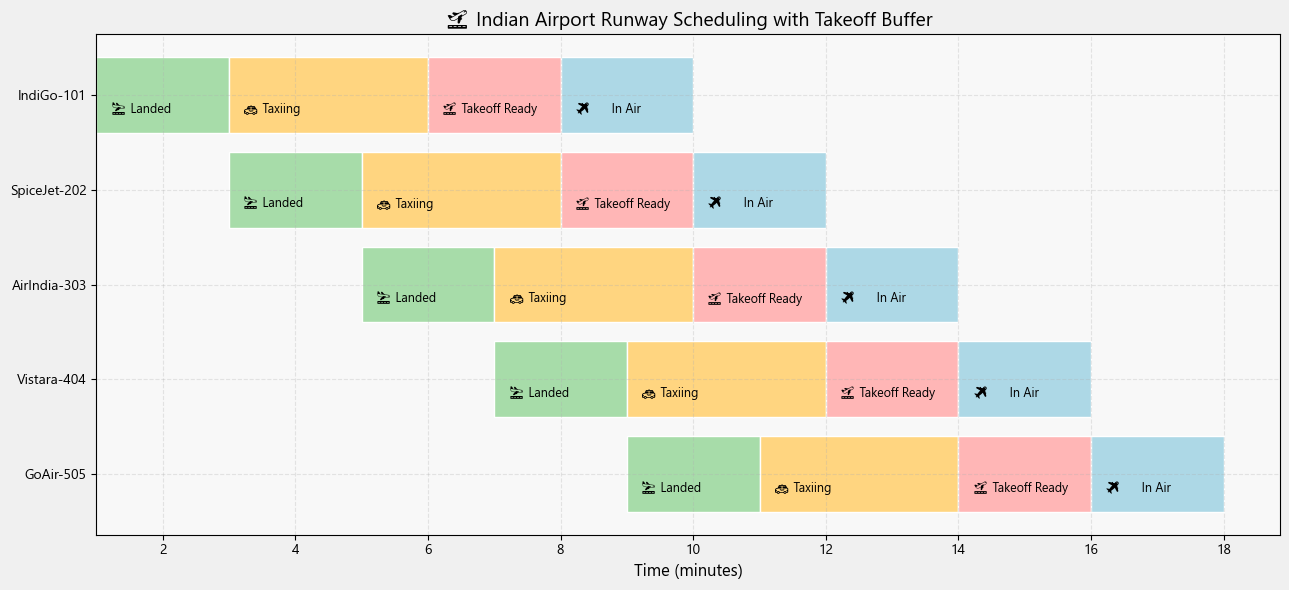

In [7]:
# Plot
fig, ax = plt.subplots(figsize=(13, 6))
unique_aircrafts = [ac[0] for ac in aircrafts]

for i, ac in enumerate(unique_aircrafts):
    y = len(unique_aircrafts) - i
    ac_data = [h for h in history if h["aircraft"] == ac]
    for entry in ac_data:
        width = BASE_TIME_WINDOWS[entry["status"]]
        # Add buffer to width for "Takeoff Ready"
        if entry["status"] == "Takeoff Ready":
            width += 1

        ax.barh(
            y, width,
            left=entry["timestamp"],
            color=colors[entry["status"]],
            edgecolor='white',
            height=0.8
        )
        label = f"{icons.get(entry['status'], '')} {entry['status']}"
        ax.text(entry["timestamp"] + 0.2, y - 0.15, label, fontsize=9, va='center')
# Axes setup
ax.set_yticks(range(1, len(unique_aircrafts) + 1))
ax.set_yticklabels(reversed(unique_aircrafts))
ax.set_xlabel("Time (minutes)", fontsize=12)
ax.set_title("🛫 Indian Airport Runway Scheduling with Takeoff Buffer", fontsize=14)
ax.set_facecolor("#F8F8F8")
fig.patch.set_facecolor('#F0F0F0')
ax.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()